In [1]:
import penemuu
import glob
import json
import spacy
import json

import en_core_web_sm
import en_core_web_md
#import en_core_web_lg
from spacy.pipeline import EntityRuler
from spacy import displacy
from penemuu import TestFunctions

from collections import defaultdict
from collections import Counter

from itertools import product

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

Generate corpus of biomedical abstracts annotated with named entities (bacterial species and habitats)
and extract sentences that contain at least one entity of each type.

In [2]:
"""
Pubmed files were downloaded using easy_pubmed_batch_downloads.R (easyPubMed R library) with a query
for "foodborne bacterial infections".

Each file contains 100 entries in MedLine format.

Available titles and/or abstracts are extracted from each entry, combined, and used to populate a 
PassageCorpus object.
"""
pubmed_files = glob.glob('resources/pubmed/bacteria_foodborne_disease_200115/*txt')
corpus = penemuu.PassageCorpus()

for file in pubmed_files:
    corpus.add_medline_records_from_file(file)

In [3]:
"""
jsonl file for entity ruler was generated from NCBI taxonomy dump file (2/21) (bacteria) and BioNLP 
bacterial biotope .obo reference file (habitats).

PassageAnnotator contains a spaCy pipeline with an EntityRuler derived from the jsonl file.
"""
jsonl = 'resources/entity_ruler_bacteria_habitat_200130.jsonl'

annotator = penemuu.PassageAnnotator(lang_model_to_use='en_core_web_md')
annotator.add_entity_ruler_from_jsonl(jsonl)

Entity ruler generated from jsonl at resources/entity_ruler_bacteria_habitat_200130.jsonl
Entity ruler added to spacy pipeline.
PySBDFactory added to spacy pipeline.


In [4]:
"""
Text passages are annotated for named entities and sentences containing at least 1 entity of each type are
extracted and written to a file.
"""    
outfile = 'resources/test_sentences_with_bac_and_hab_ents_200211.txt'
sentences = TestFunctions.get_single_sentences_with_entities_by_labels(corpus, annotator, ['BACTERIA', 'HABITAT'], outfile)

"""
Filtering sentences to those with a root that is a verb or auxiliary verb eliminates titles (which are 
often not full sentences) and sentence fragments due to sentence boundary detection errors.
"""

'\nFiltering sentences to those with a root that is a verb or auxiliary verb eliminates titles (which are \noften not full sentences) and sentence fragments due to sentence boundary detection errors.\n'

In [5]:
"""
Separating full and non-full sentences.

Full sentences require:
    -A verb.
    -A subject.

Non-full sentences in text passages are the result of:
    -Paper titles, which are frequently incomplete sentences.
    -Sentence boundary detection errors, often resulting from the ubiquitous use of abbreviations in biomedical
    abstracts.
    -Genuinely incomplete sentences.

Paper titles:
    The logical fix for this is to handle titles and abstracts separately.  My intuition is that a title containing
    two named entities will almost always be positively linking the two.  To be added.

Sentence boundary detection:
    PassageAnnotator includes a PySBDFactory component (https://spacy.io/universe/project/python-sentence-boundary-disambiguation).
    I will manually add more scientific abbreviations to its abbrev. list as I encounter them.

Incomplete sentences:
    These seem to throw off spaCy dependency parsing in unpredictable ways
    
"""

full_sentences = []
sentences_without_verbs = []
sentences_with_verbs_without_subjs = []

for sent in sentences:
    
    #Verb detection
    sent_verbs = ([i for i in filter(lambda w: w.pos_ in ['VERB', 'AUX'], sent)])
    if sent_verbs:
        
        #Subject detection
        sent_subjs = ([i for i in filter(lambda w: w.dep_ in ['nsubj', 'nsubjpass', 'csubj'], sent)])
        if sent_subjs:
            full_sentences.append(sent)
        else:
            sentences_with_verbs_without_subjs.append(sent)

    else:
        sentences_without_verbs.append(sent)
        

In [6]:
"""
Sentences without verbs are mostly short fragments.

Even ones that appear very clear could be misleading without context:

"c. jejuni in the farm environment.,"

Is not useful without knowing if it's preceded by:

"Thousands of samples corroborated..."
or:
"Thousands of samples failed to corroborate..."

These may still be useful when looking at the abstract as a whole.
"""

sentences_without_verbs

[e. coli as foodborne pathogens in raw chicken and beef meat in nile delta, egypt.,
 of the 29 spinach e. coli,
 e. coli colonization and existence of common bile duct and gallbladder stones (p value 0.028).,
 l. monocytogenes from the brazilian dairy industry.,
 the mechanisms responsible for the possible correlation between resistance to antibiotics and to acid or salt stress in l. monocytogenes,
 l. monocytogenes in bovine raw milk samples.,
 s. aureus in food products.,
 human enteric pathogens, such as salmonella spp.,
 e. coli isolates from poultry farms in egypt.,
 c. jejuni colonization in poultry in the presence of probiotics.,
 chicken c. jejuni inoculation.,
 s. aureus st5 isolates from food sources and diversity in se profiles and antibiotic resistance patterns.,
 e. coli as a cause of bovine mastitis in turkey.,
 sixteen human and animal isolates of s. enterica,
 l. monocytogenes from food to humans.,
 k. pneumoniae to antibiotic-resistant human infections.,
 resistant e. 

In [7]:
"""
Sentences with verbs but no subjects are trickier.

Some are incoherent fragments:
    "b. pinnipedialis dna to verify brucella detection by the is 711 primer-probe within fish dna."

Others are coherent but have overly passive voice:
    "e. coli (escherichia coli o157:h7-gfp b6-914), salmonella (salmonella enterica serovar enteritidis phage-type pt21), 
    and the gram-positive bacteria listeria (listeria innocua), as well as environmental microorganisms 
    derived from local river water."
    
The latter may be usable, but may be tricky to separate from the former.
    
"""

print("Sentence:")
print(sentences_with_verbs_without_subjs[0])

print("\nRoot:")
print(sentences_with_verbs_without_subjs[0].root)

displacy.render(sentences_with_verbs_without_subjs[0])

Sentence:
c. jejuni isolates collected by national animal health monitoring system (nahms) dairy studies in 2002, 2007, and 2014.

Root:
isolates


In [8]:
verbs_used = []
verb_tokens_used = []
verb_lemmas_used = []
for sent in full_sentences:
    
    if sent.root.pos_ in ['VERB', 'AUX']:
        verbs_used.append(sent.root.text)
        verb_tokens_used.append(sent.root)
        verb_lemmas_used.append(sent.root.lemma_)
    elif sent.root.pos_ not in ['NOUN', 'PROPN']:
        print(sent)
        print(sent.root, sent.root.pos_)

in conclusion, cattle slaughtered in south african rural abattoirs harbour diverse salmonella serovars that are resistant to antimicrobials, which could be a public health risk.
in ADP
the campylobacter and arcobacter genera encompass closely related species that are ubiquitous in nature and are harboured in the gastrointestinal tract of many animals, including food-producing animals (cattle, sheep, pigs and poultry).
encompass ADJ
because cattle e. coli o104:h7 strains possess stx1c and genes that code for enterohemolysin and a variety of adhesins
because SCONJ
enterotoxigenic clostridium perfringens, a leading foodborne pathogen can be cross-contaminated from food processing stainless steel (ss) surfaces to the finished food products.
contaminated ADJ
c. jejuni distinct from those carried by bovine livestock.
distinct ADJ
salmonella and campylobacter cause foodborne enteritis mainly via the consumption of raw/undercooked contaminated poultry meat and products.
foodborne ADJ
c. perfri

In [9]:
print("Number of sentences: %d" % len(full_sentences))

print("Number of verb roots: %d" % len(verbs_used))

counted_verbs_used = Counter(verbs_used).most_common()
print("Number of verbs used: %d" % len(counted_verbs_used))

counted_verb_lemmas_used = Counter(verb_lemmas_used).most_common()
print("Number of verb lemmas used: %d" % len(counted_verb_lemmas_used))

Number of sentences: 2363
Number of verb roots: 2178
Number of verbs used: 457
Number of verb lemmas used: 313


In [10]:
counted_verb_lemmas_used

[('be', 608),
 ('show', 62),
 ('use', 55),
 ('isolate', 51),
 ('detect', 50),
 ('investigate', 50),
 ('identify', 46),
 ('find', 35),
 ('report', 35),
 ('indicate', 30),
 ('cause', 29),
 ('suggest', 28),
 ('reveal', 27),
 ('provide', 25),
 ('demonstrate', 25),
 ('evaluate', 22),
 ('associate', 22),
 ('describe', 21),
 ('have', 20),
 ('collect', 20),
 ('examine', 19),
 ('observe', 19),
 ('test', 18),
 ('perform', 15),
 ('highlight', 15),
 ('develop', 15),
 ('characterize', 14),
 ('determine', 14),
 ('conduct', 13),
 ('contaminate', 13),
 ('confirm', 13),
 ('analyze', 12),
 ('compare', 12),
 ('carry', 12),
 ('represent', 11),
 ('result', 11),
 ('assess', 11),
 ('include', 11),
 ('require', 10),
 ('aim', 10),
 ('understand', 10),
 ('consider', 10),
 ('need', 10),
 ('exhibit', 9),
 ('lead', 8),
 ('increase', 8),
 ('apply', 8),
 ('recognize', 8),
 ('obtain', 8),
 ('inoculate', 8),
 ('pose', 8),
 ('present', 8),
 ('occur', 7),
 ('select', 7),
 ('strain', 7),
 ('reduce', 7),
 ('trace', 7),
 (

In [15]:
def generate_verb_span_from_sent_span(nlp, sent_span):
    verbs = [token.text for token in sent_span if token.pos_ in ['VERB', 'AUX']]
    verb_span = nlp(' '.join(verbs))
    return verb_span

In [101]:
"""
Full sentence and sentence root similarity
"""

n_dim = 250

sent_sim_array = np.zeros((n_dim, n_dim))
root_sim_array = np.zeros((n_dim, n_dim))

i = 0 
for sent_1 in full_sentences[:n_dim]:
    j = 0
    
    for sent_2 in full_sentences[:n_dim]:
        sent_sim_array[i][j] = sent_1.similarity(sent_2)
        root_sim_array[i][j] = sent_1.root.similarity(sent_2.root)
            
        j += 1
    i += 1

In [102]:
"""
Sentence verb similarity
"""

verb_spans = []

for sent in full_sentences[:n_dim]:    
    verb_spans.append(generate_verb_span_from_sent_span(annotator.nlp, sent))

verb_sim_array = np.zeros((n_dim, n_dim))

i = 0 
for verb_span_1 in verb_spans[:n_dim]:
    j = 0
    for verb_span_2 in verb_spans[:n_dim]:
        verb_sim_array[i][j] = verb_span_1.similarity(verb_span_2)   
        j += 1
    i += 1

In [89]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

Sentence similarity by average token similarity.


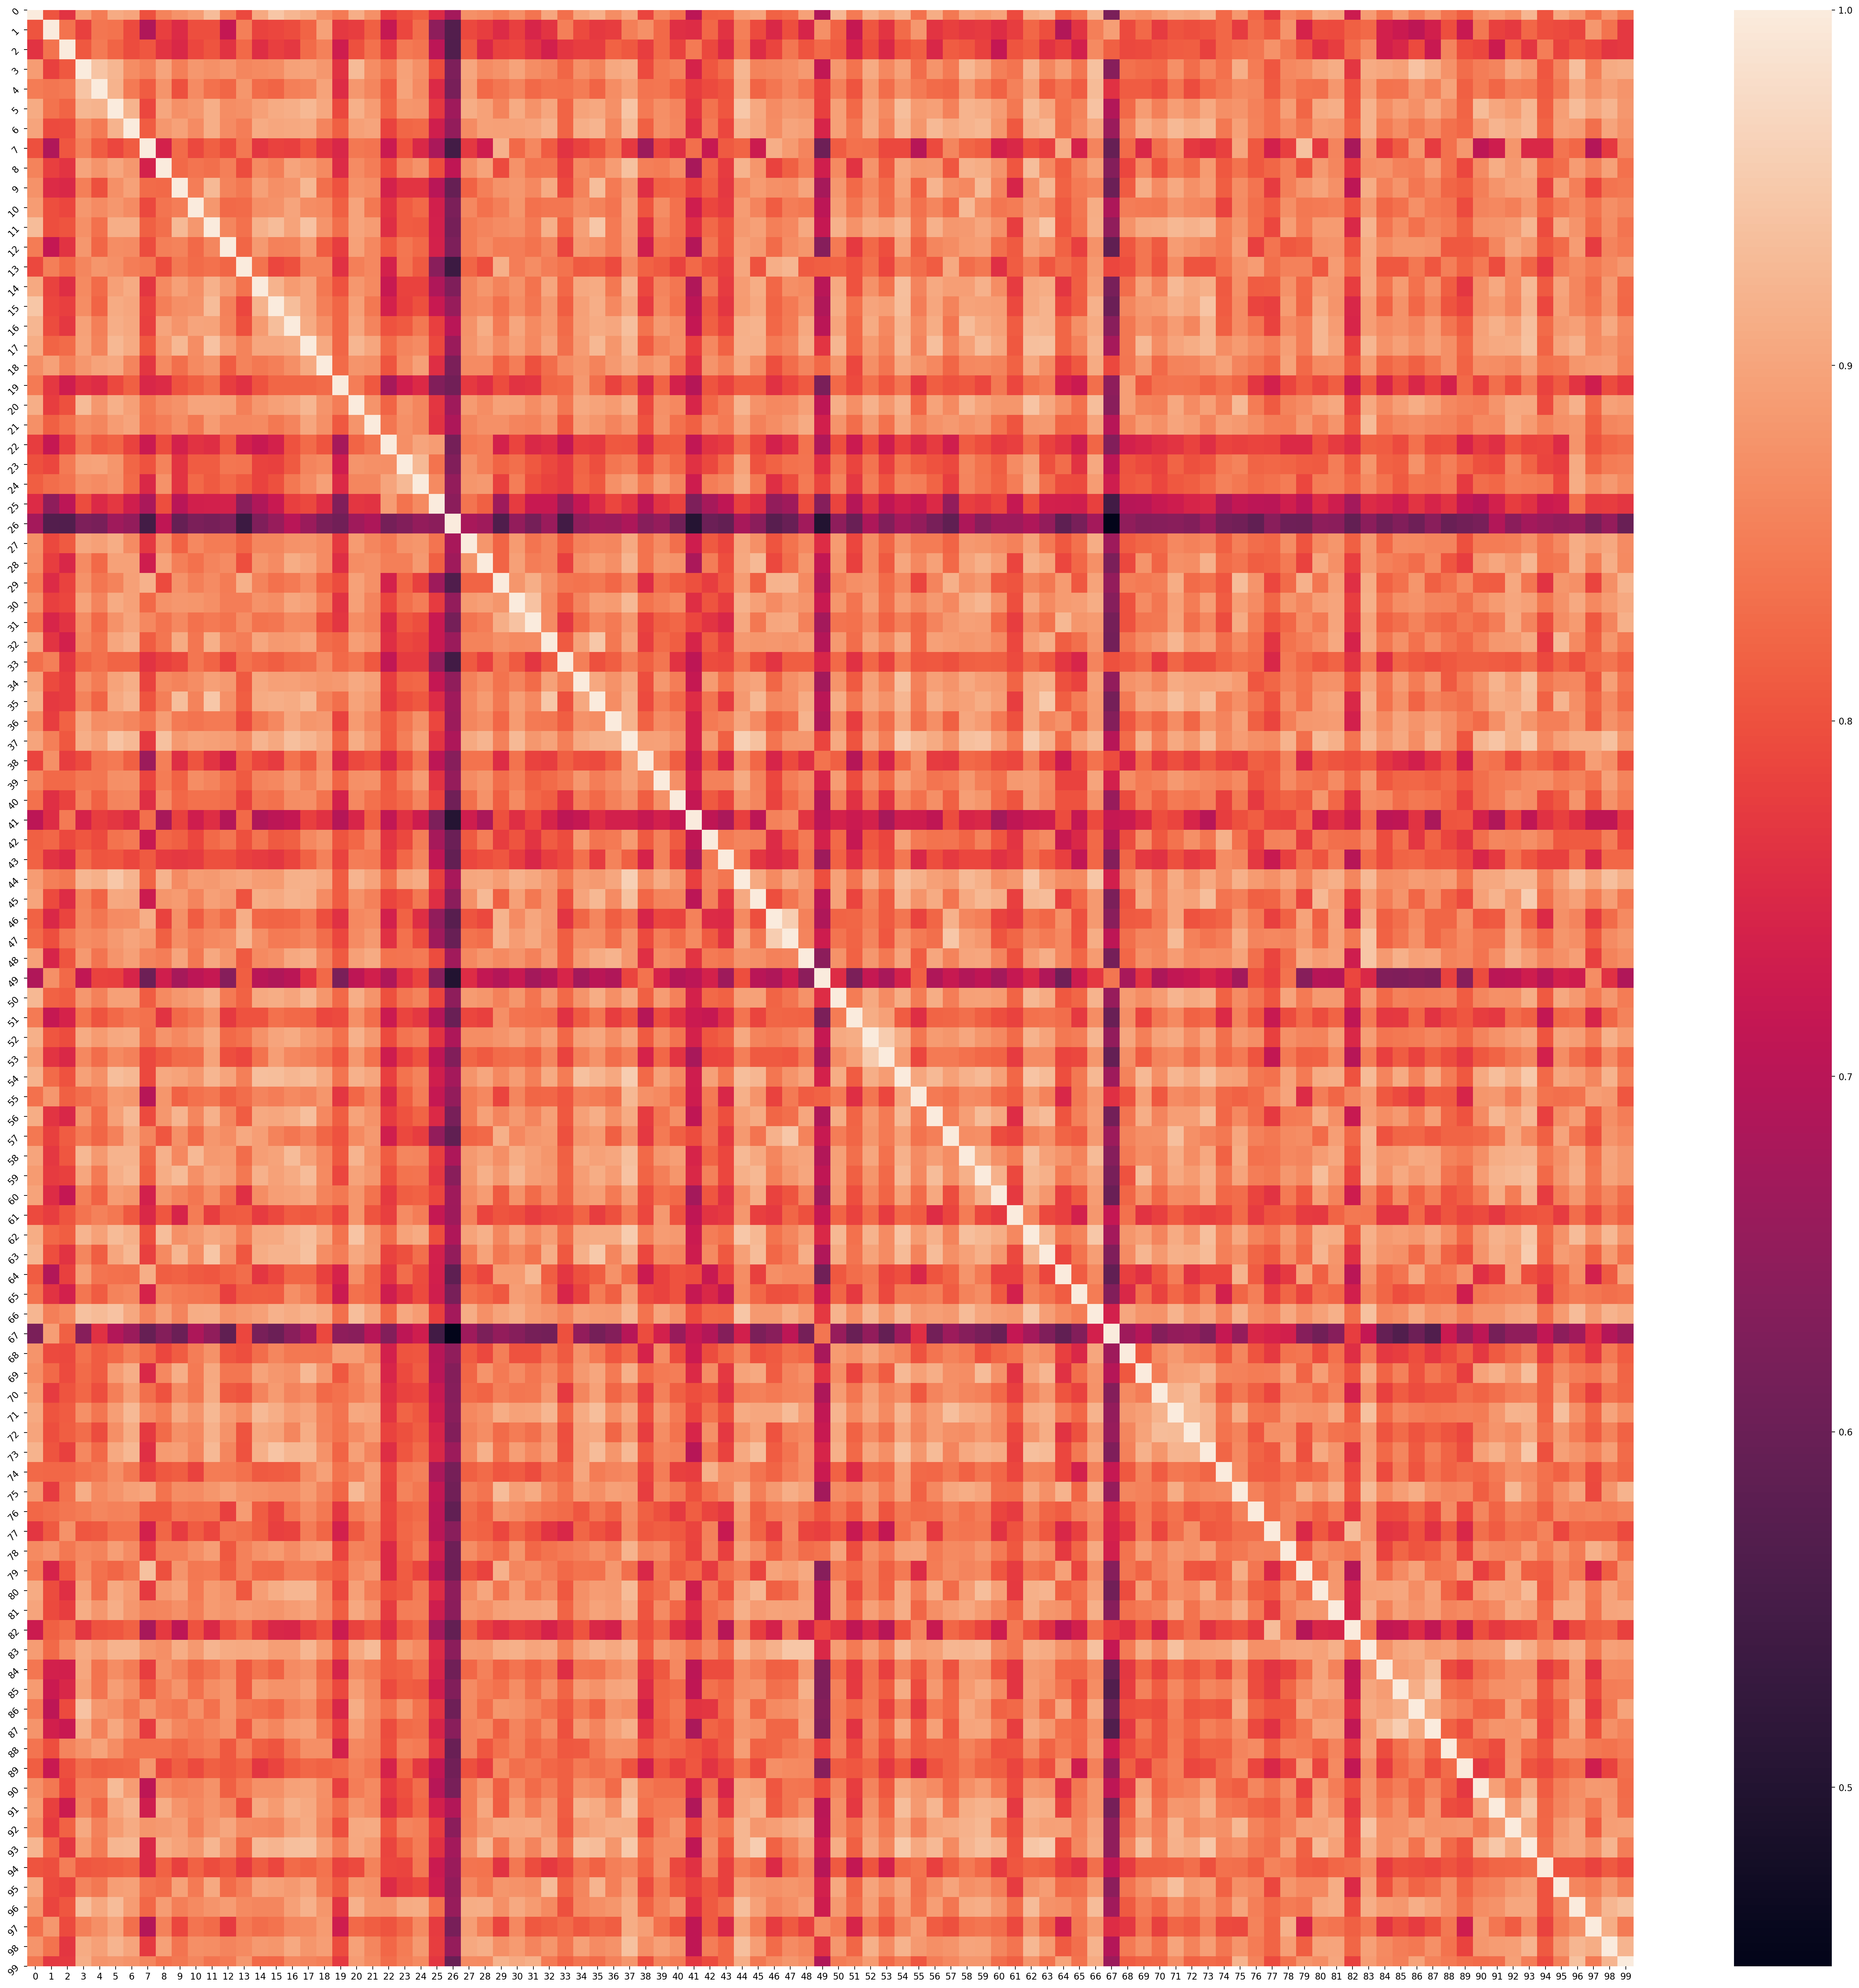

In [91]:
print("Sentence similarity by average token similarity.")

plt.figure(figsize=(40, 40))
ax = sns.heatmap(sent_sim_array, xticklabels=1, yticklabels=1)
plt.yticks(rotation=45)

plt.show()

Sentence similarity by root embedding vectors.


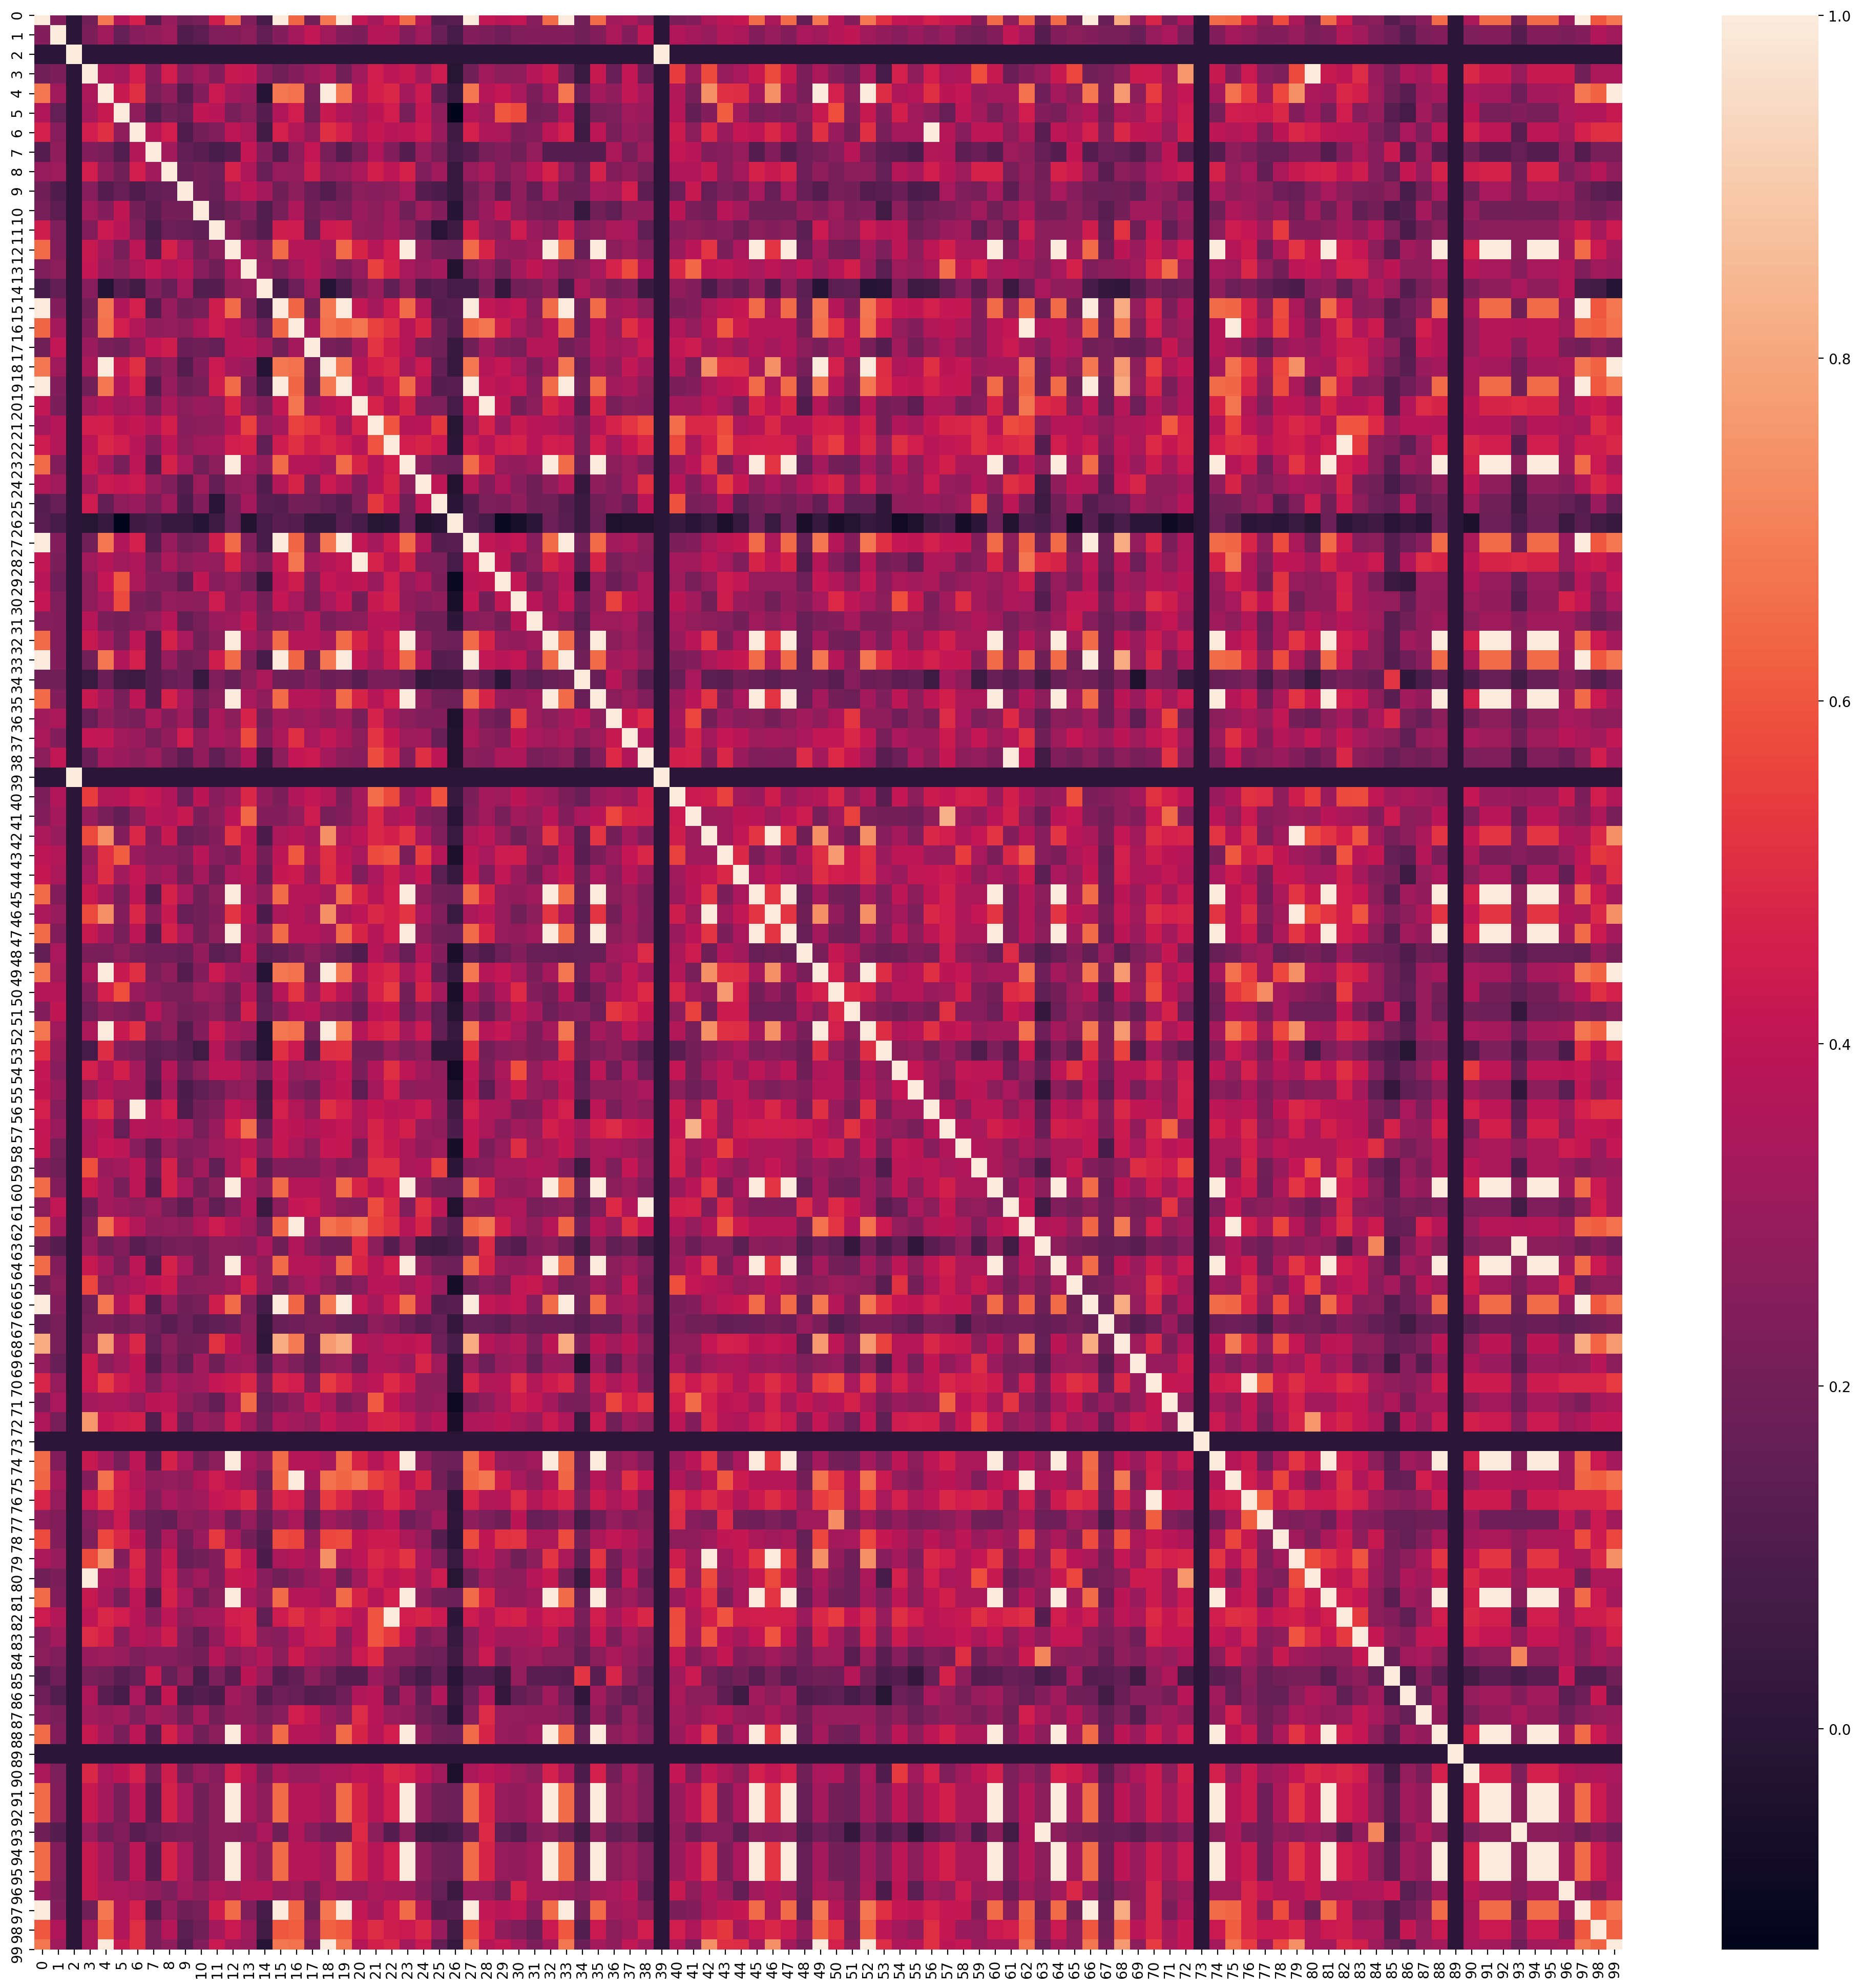

In [61]:
print("Sentence similarity by root embedding vectors.")

plt.figure(figsize=(25, 25))
sns.heatmap(root_sim_array)

Sentence similarity by verb embedding vectors.


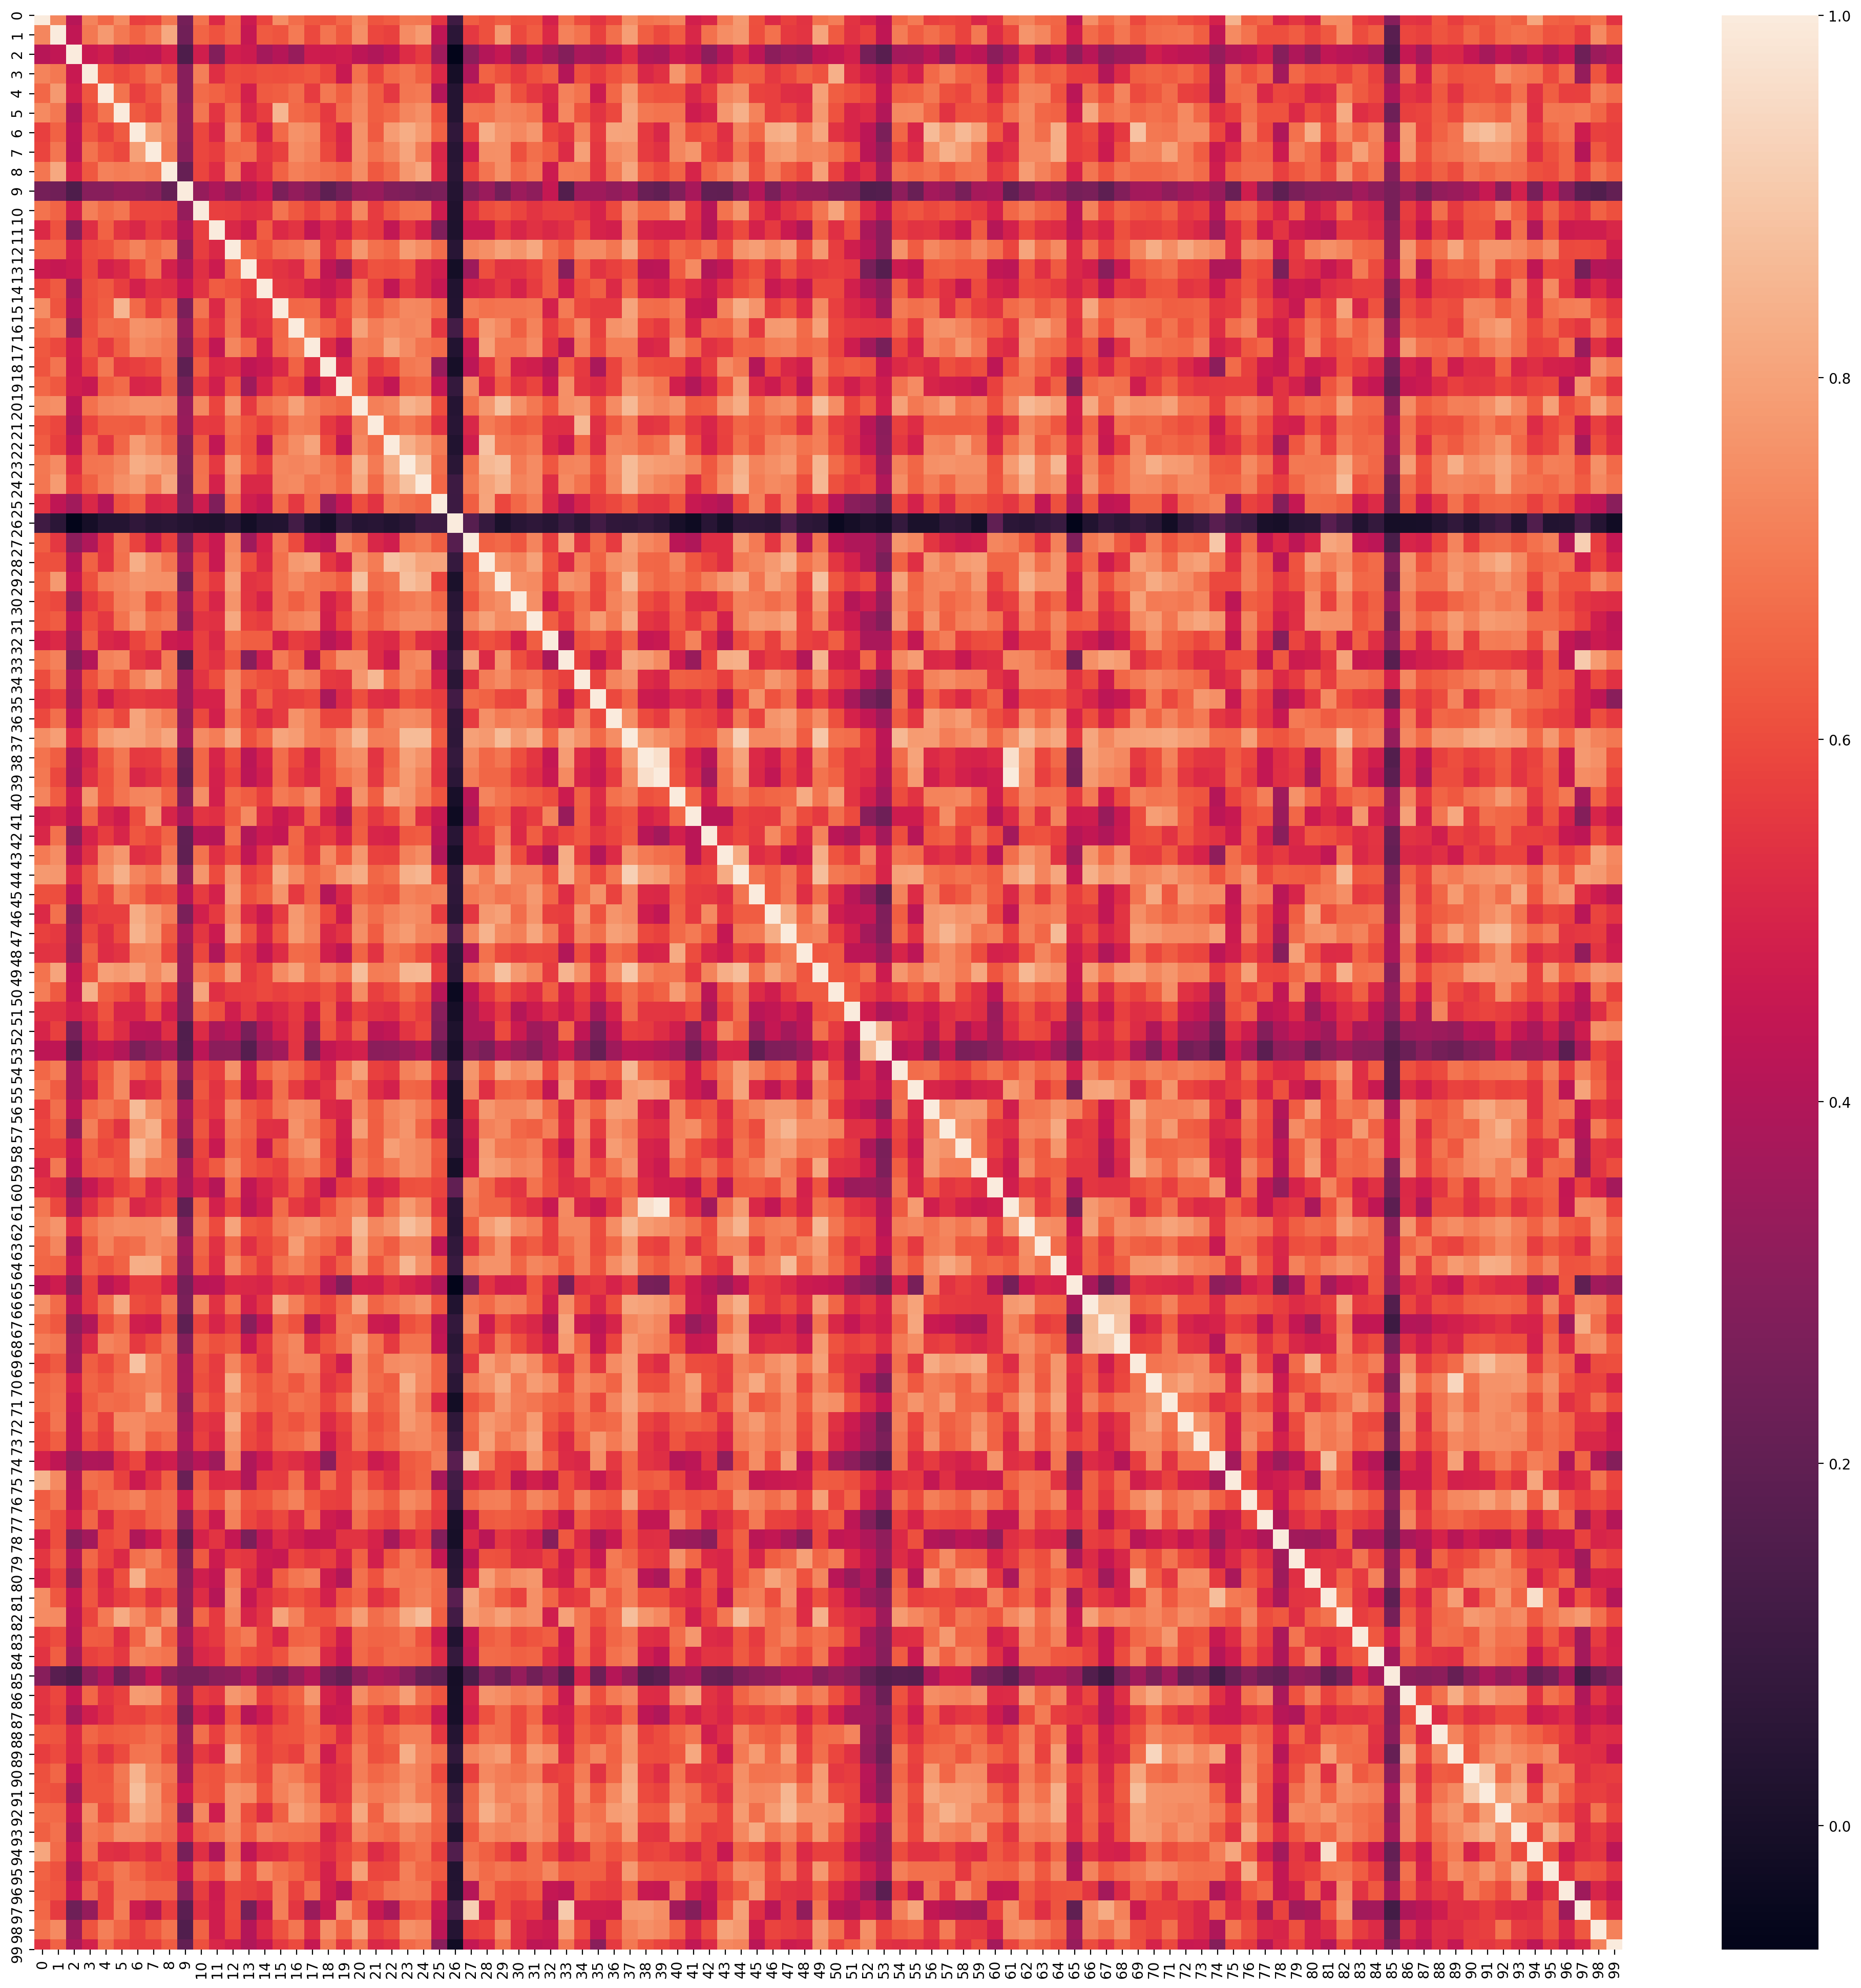

In [62]:
print("Sentence similarity by verb embedding vectors.")

plt.figure(figsize=(25, 25))
sns.heatmap(verb_sim_array)

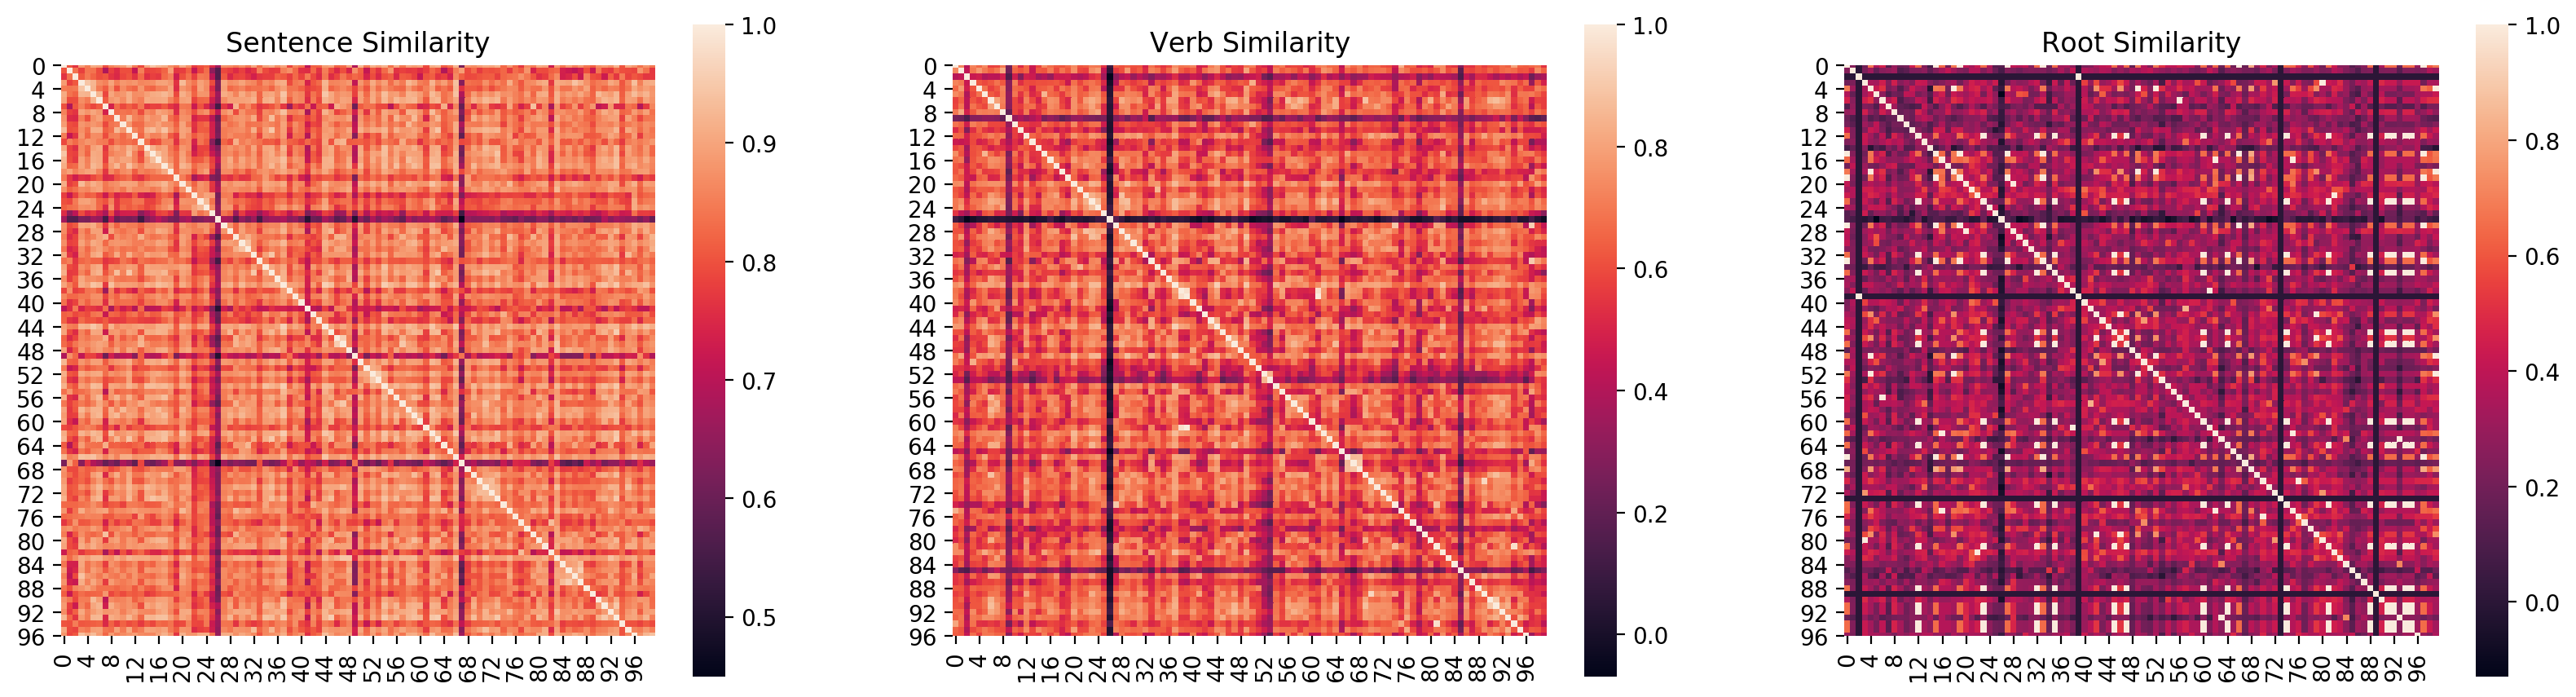

In [63]:
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(3, 3, 1) # row, column, position
ax2 = fig.add_subplot(3, 3, 2)
ax3 = fig.add_subplot(3, 3, 3)

ax1.set_title('Sentence Similarity')
sns.heatmap(data=sent_sim_array, ax=ax1, square=True,  cbar_kws={'shrink': .9})

ax2.set_title('Verb Similarity')
sns.heatmap(data=verb_sim_array, ax=ax2, square=True,  cbar_kws={'shrink': .9})

ax3.set_title('Root Similarity')
sns.heatmap(data=root_sim_array, ax=ax3, square=True,  cbar_kws={'shrink': .9})

In [38]:
idx_1 = 27
idx_2 = 73

sent_1 = full_sentences[idx_1]
sent_2 = full_sentences[idx_2]
print("Sentence 1 index: %d" % idx_1)
print("Sentence 1: %s" % sent_1.text)
print("Sentence 1 root: %s" % sent_1.root.text)
print("Sentence 1 verbs: %s" % verb_spans[idx_1].text)
print('\n')

print("Sentence 2 index: %d" % idx_2)
print("Sentence 2: %s" % sent_2.text)
print("Sentence 2 root: %s" % sent_2.root.text )
print("Sentence 2 verbs: %s" % verb_spans[idx_2].text)
print('\n')


print("Sentence similarity (all sentence tokens): %f" % (sent_1.similarity(sent_2)))
print("Sentence similarity (root token)): %f" % (sent_1.root.similarity(sent_2.root)))
print("Sentence similarity (all verb tokens): %f" % (verb_spans[idx_1].similarity(verb_spans[idx_2])))

Sentence 1 index: 27
Sentence 1: in culture-positive cod tissue, the is 711 limit of detection was ~1 genome copy of brucella.
Sentence 1 root: was
Sentence 1 verbs: is was


Sentence 2 index: 73
Sentence 2: however, given the number of different emerging salmonella serovars a regular review of salmonella control strategies from farm to fork is required.
Sentence 2 root: serovars
Sentence 2 verbs: given emerging fork is required


Sentence similarity (all sentence tokens): 0.862809
Sentence similarity (root token)): 0.000000
Sentence similarity (all verb tokens): 0.651396


In [107]:
"""
Clustering methods

"""

from sklearn.cluster import DBSCAN

dens_scan = DBSCAN(eps=0.1, min_samples=1).fit_predict(verb_sim_array)

print("Density scan cluster assignments:")
print(dens_scan)

dens_scan_result = np.where(dens_scan == 73)

for i in dens_scan_result[0]:
    print(i)
    print(full_sentences[i])
    print('Root = %s' % full_sentences[i].root)
    print('Verbs = %s' % (sorted(verb_spans[i].text.split(' '))))
    print('\n')

Density scan cluster assignments:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  39  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111  18 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190  73 191 192 193  73
 194 195 196 197 198 199 200 201 202 203  47 204 205 206 207 131 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222  73 223 224 225 226
 227 228 229 230 

Sentence similarity by averaged word embedding vectors (clustered).


<Figure size 24000x24000 with 0 Axes>

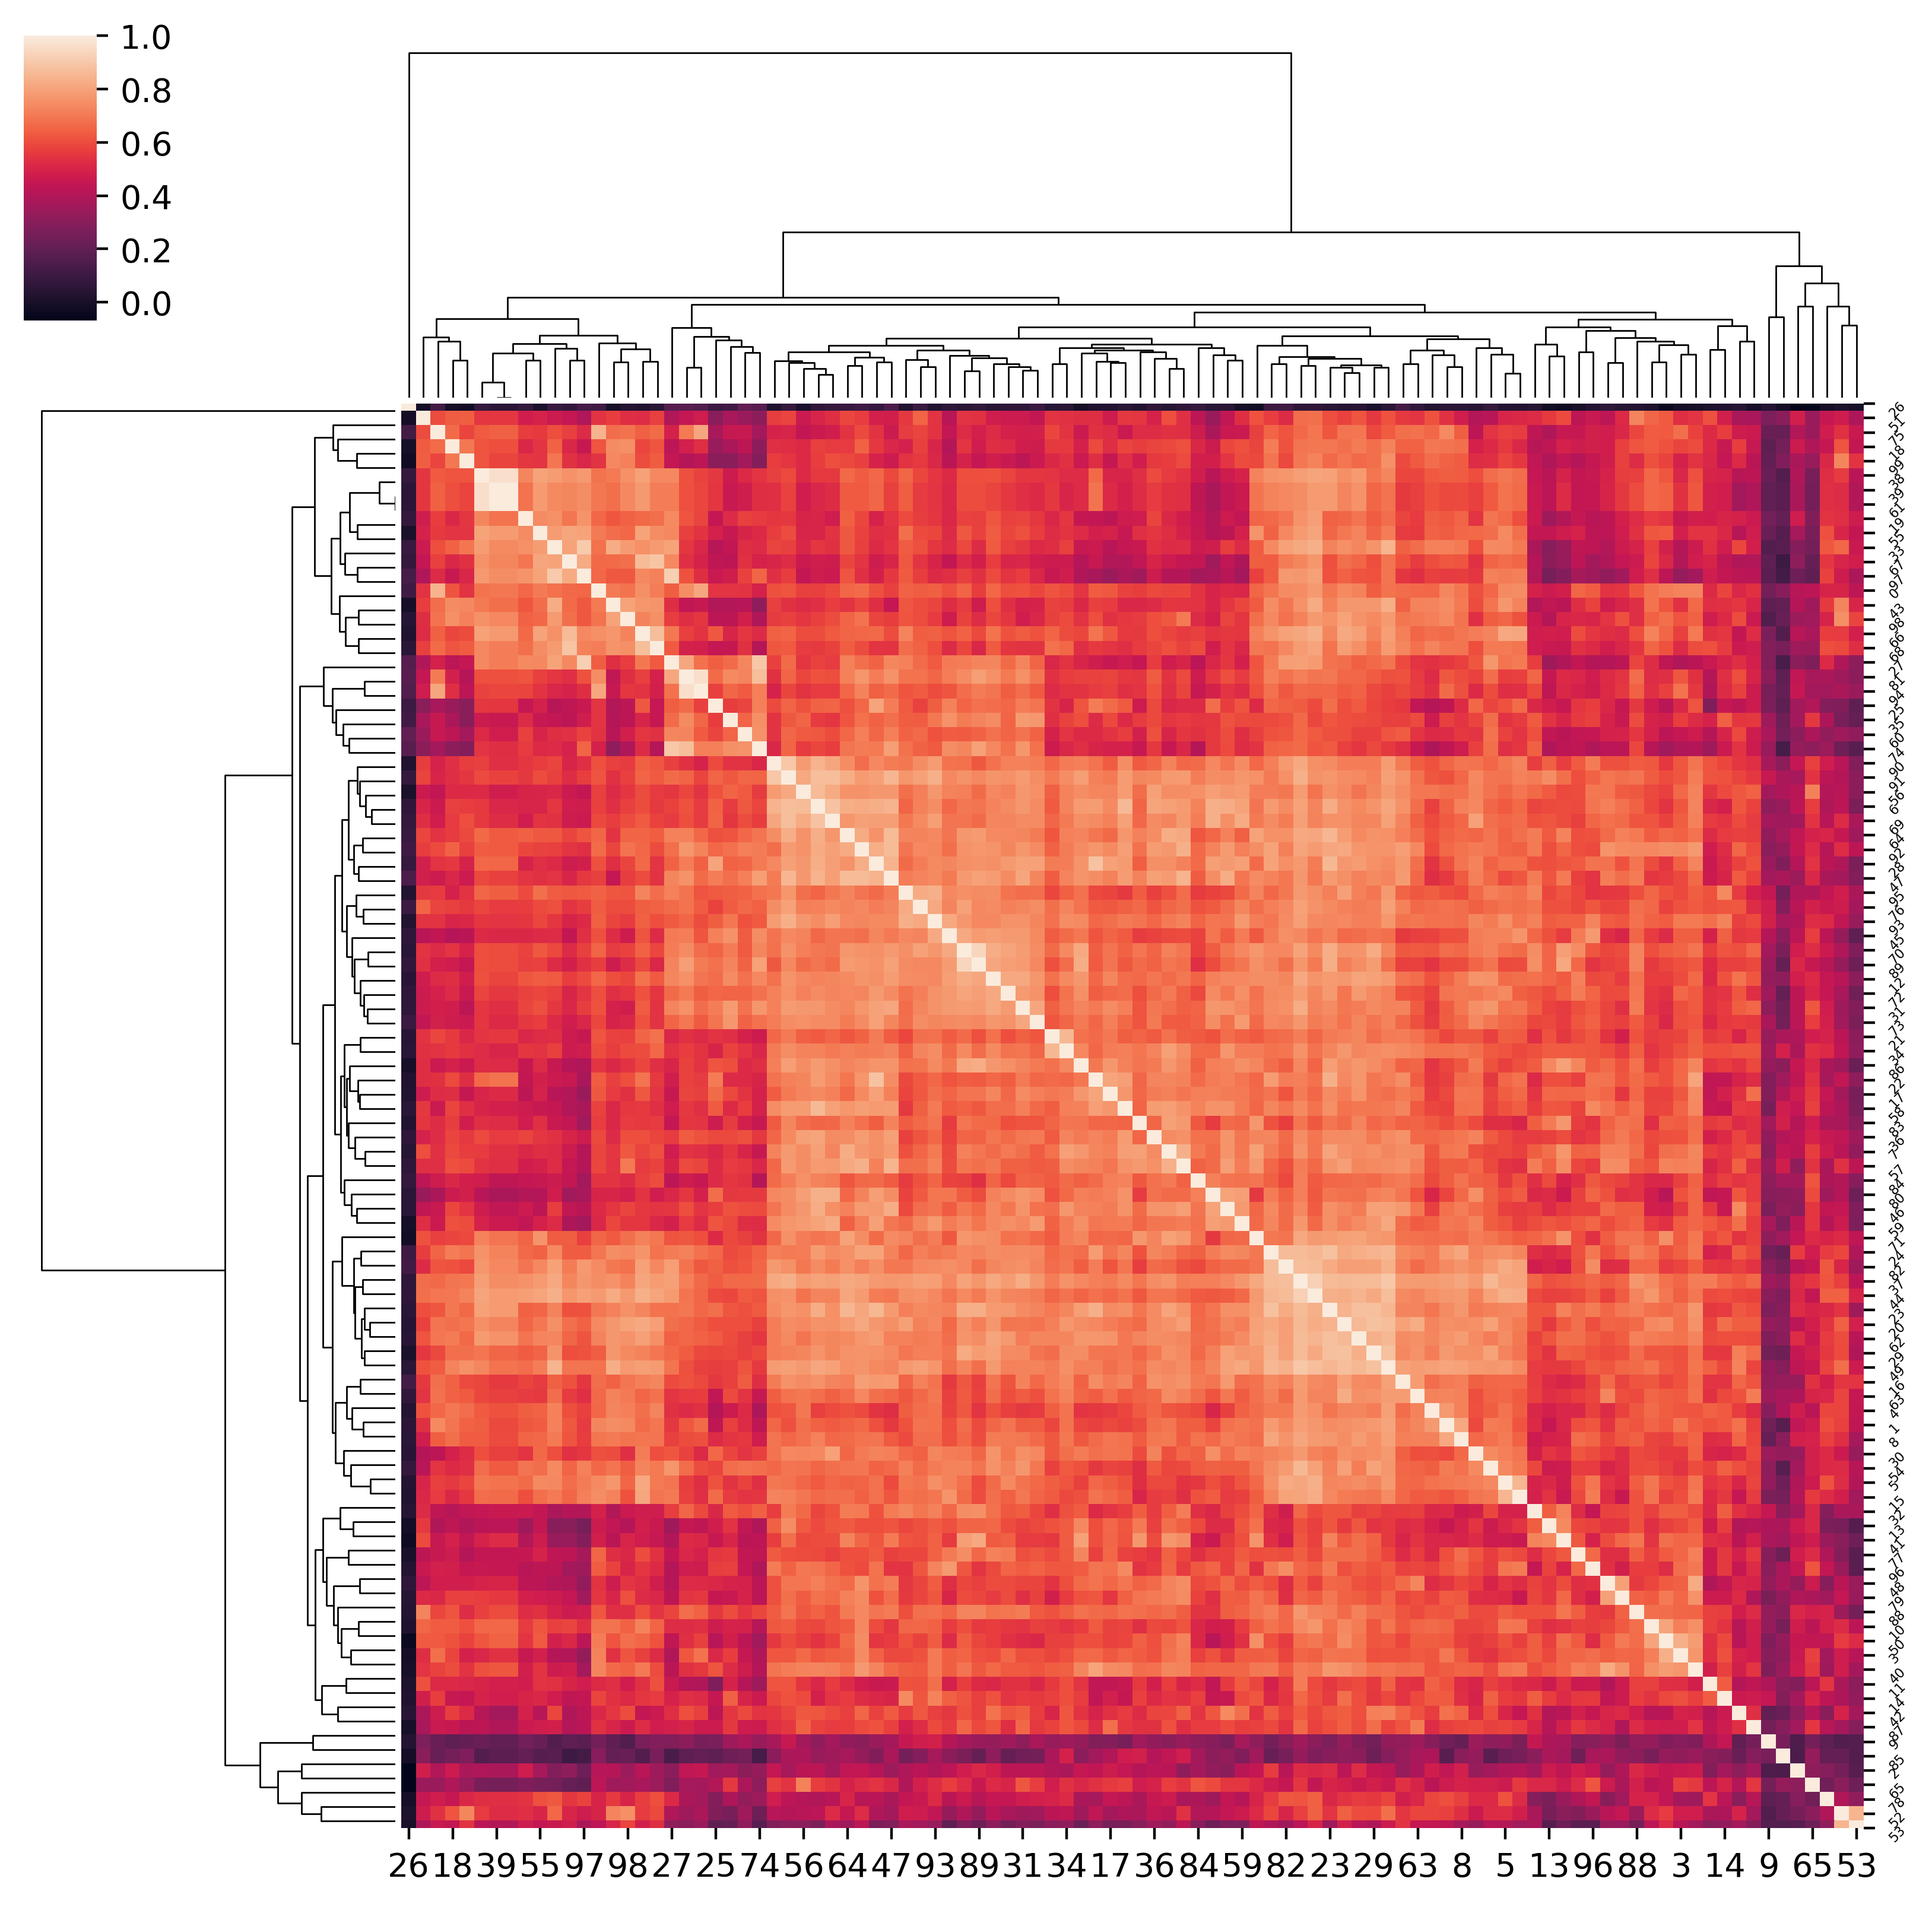

In [82]:
print("Sentence similarity by averaged word embedding vectors (clustered).")

plt.figure(figsize=(60, 60))
g = sns.clustermap(verb_sim_array, yticklabels=1)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=45, size=4)
plt.show()